<a href="https://colab.research.google.com/github/cdbolivarz/Accidentality_Predictions_Medellin/blob/master/Limpieza__y_formato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza y formato de datos
En este documento, se realiza el preprocesamiento de los datos obtenidos de los documentos de incidentes georeferenciados.

Librerias

In [1]:
# !pip install holidays_co
import pandas as pd
import glob
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
# import holidays_co

### Lectura de datos

In [2]:
all_files = glob.glob("dataset/I*.csv")

li = []

for filename in all_files:

    frame = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df = df.sort_values(by=["FECHA"])

df.head()

,X,Y,OBJECTID,RADICADO,FECHA,HORA,DIA,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,DIA_NOMBRE,MES,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD
89727,-75.579329,6.209160,211341,1424110,2014/01/01 00:00:00+00,04:20:00,1,2014,Choque,CR 50 CL 4,CR 050 004 000 00000,1507,Malla vial,HERIDO,Campo Amor,Guayabal,Tramo de via,MIÉRCOLES,1,NaN,833779.95,1178599.23,-75.579329,6.209160
89728,-75.703816,6.221806,211342,1424116,2014/01/01 00:00:00+00,05:30:00,1,2014,Atropello,Con,000 00000,NaN,No Ubicada,HERIDO,NaN,NaN,Lote o Predio,MIÉRCOLES,1,NaN,820000.00,1180000.00,-75.703816,6.221806
89726,-75.565164,6.242722,211340,1424107,2014/01/01 00:00:00+00,09:10:00,1,2014,Choque,CL 44 CR 43,CL 044 043 000 00000,1013,Malla vial,HERIDO,Barrio Colón,La Candelaria,Interseccion,MIÉRCOLES,1,NaN,835348.01,1182311.63,-75.565164,6.242722
89725,-75.555400,6.252163,211339,1424101,2014/01/01 00:00:00+00,08:50:00,1,2014,Choque,CR 39 CL 60,CR 039 060 000 00000,0803,Malla vial,HERIDO,San Miguel,Villa Hermosa,Tramo de via,MIÉRCOLES,1,NaN,836428.72,1183355.92,-75.555400,6.252163
89724,-75.564683,6.249282,211338,1424096,2014/01/01 00:00:00+00,08:00:00,1,2014,Otro,CL 52 CR 46,CL 052 046 000 00000,1019,Malla vial,HERIDO,La Candelaria,La Candelaria,Tramo de via,MIÉRCOLES,1,NaN,835401.20,1183037.23,-75.564683,6.249282


Que columnas tienen valores nulos

In [3]:
df.isna().any()

X                False
Y                False
OBJECTID         False
RADICADO          True
FECHA            False
HORA             False
DIA              False
PERIODO          False
CLASE             True
DIRECCION        False
DIRECCION_ENC     True
CBML              True
TIPO_GEOCOD      False
GRAVEDAD         False
BARRIO            True
COMUNA            True
DISENO            True
DIA_NOMBRE       False
MES              False
MES_NOMBRE        True
X_MAGNAMED       False
Y_MAGNAMED       False
LONGITUD         False
LATITUD          False
dtype: bool

Formato datos

In [4]:
#Eliminar filas con NA y columnas que no consideramos importantes para el modelo.
#Asignar mismos nombres a los tipos de accidentes (CLASE)
def format(df):
  df = df.drop(['X', 'Y', 'OBJECTID', 'RADICADO', 'DIRECCION', 'DIRECCION_ENC',
              'CBML', 'TIPO_GEOCOD', 'DISENO', 'MES_NOMBRE', 'X_MAGNAMED',
              'Y_MAGNAMED'], axis=1)
  df = df.dropna(subset=['CLASE', 'BARRIO', 'COMUNA'])

  df["CLASE"].replace({"Caída de Ocupante": "Caida Ocupante",
                       "Caida de Ocupante": "Caida Ocupante",
                       "Caída Ocupante": "Caida Ocupante",
                       "Choque ": "Choque"}, inplace=True)

  return df

df = format(df)
df.columns = df.columns.str.lower()
df = df.reset_index()
df = df.drop(['index'],axis=1)
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud
0,2014/01/01 00:00:00+00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160
1,2014/01/01 00:00:00+00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722
2,2014/01/01 00:00:00+00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163
3,2014/01/01 00:00:00+00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282
4,2014/01/01 00:00:00+00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498


## Fechas

Primero se cambia el timpo de la comuna *fecha* por el tipo **datetime**

In [5]:
fechas = df['fecha']
df['fecha'] = pd.to_datetime(fechas)

Luego se crea la columna *dia_anno* para saber a que dia del año pertenece cada fila y la columna semana donde va la semana del año


In [6]:
df['dia_anno']=df['fecha'].dt.dayofyear
df['semana']=df['fecha'].dt.isocalendar().week

In [7]:
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud,dia_anno,semana
0,2014-01-01 00:00:00+00:00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160,1,1
1,2014-01-01 00:00:00+00:00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722,1,1
2,2014-01-01 00:00:00+00:00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163,1,1
3,2014-01-01 00:00:00+00:00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282,1,1
4,2014-01-01 00:00:00+00:00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498,1,1


Haciendo uso de la libreria _**holidays_co**_ se creo un archivo *festivos.csv* que contiene las fechas y si la fecha es festivo o no, para hacer un join con el dataframe actual, ya que la ejecucion de esta libreria toma al rededor de 5min

In [8]:
# codigo empleadon holidays_co
# def festivo(row):
#     row['festivo'] = holidays_co.is_holiday_date(row['fecha'])
#     return row
# dfcopy = dfcopy.apply(festivo, axis=1)

In [9]:
festivos = pd.read_csv('dataset/festivos.csv')
df = df.join(festivos['festivo'])

Filas con errores ortograficos en algunas columnas

In [10]:
df['comuna'].drop_duplicates()

0              Guayabal
1         La Candelaria
2         Villa Hermosa
4          Buenos Aires
5               Popular
              ...      
167555        Altavista
167825     Barrio Colón
167826         Girardot
167915       Campo Amor
168035        Andalucía
Name: comuna, Length: 84, dtype: object

In [11]:
df['barrio'].drop_duplicates()

0               Campo Amor
1             Barrio Colón
2               San Miguel
3            La Candelaria
4             La Milagrosa
                ...       
187678            El Uvito
188957                7001
189040                9004
195130    Volcana Guayabal
201286             El Plan
Name: barrio, Length: 339, dtype: object

In [12]:
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud,dia_anno,semana,festivo
0,2014-01-01 00:00:00+00:00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160,1,1,True
1,2014-01-01 00:00:00+00:00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722,1,1,True
2,2014-01-01 00:00:00+00:00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163,1,1,True
3,2014-01-01 00:00:00+00:00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282,1,1,True
4,2014-01-01 00:00:00+00:00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498,1,1,True


In [13]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
len(df['barrio'].drop_duplicates())

339

Todos las columnas de *clase, gravedad, barrio, comuna, dia_nombre* se pasaron a miniuscula para evitar posibles inconveniesntes futuros

In [14]:
df['clase'] = df['clase'].str.lower()
df['gravedad'] = df['gravedad'].str.lower()
df['barrio'] = df['barrio'].str.lower()
df['comuna'] = df['comuna'].str.lower()
df['dia_nombre'] = df['dia_nombre'].str.lower()

## Barrios


Se eliminan las filas donde el barrio sale como un número

In [15]:
for barrio in df['barrio']:
    try:
        int(barrio)
        df = df.replace({'barrio': barrio}, np.nan)
    except:
        pass
df= df.dropna(subset=['barrio'])


Para corregir los barrios donde salía **no. #**  para que salga **no.#**

In [16]:
def error_no(row):
    barrio = row['barrio'].strip()
    b = bool(re.search(r'(no)\. \d', barrio))
    if (b):
        b = barrio.split()
        barrio = ' '.join(b[0:-2])
        barrio += ' '+b[-2]+b[-1]
    row['barrio'] = barrio
    return row
df = df.apply(error_no,axis=1)

In [17]:
# Barrios con problemas
# en Medellin se supone hay 275 barrio (segun wikipedia)
# hay varios suburbanos que me parecen raros
# el barrio 'u.p.b'
# creo que todos los barrios que se llaman universidad algo estan mal (el de falcultad de minas existe)


In [18]:
df = df.replace({'barrio':{'barrio de jesús':'barrios de jesús',
                           'berlin':'berlín',
                           'loma de los bernal':'la loma de los bernal',
                           'villa liliam':'villa lilliam',
                           'barrio caicedo':'caicedo',
                           'u.p.b':'bolivariana',
                           'b. cerro  el volador':'el volador',
                           'b. cerro el volador':'el volador',
                           'facultad de minas u. nacional':'barrio facultad de minas',
                           'nueva villa de la iguaná':'villa de la iguaná',
                           'sin nombre':np.nan,
                           'laureles estadio':'laureles'
                           }})

se borran los barrios que tienen nan

In [19]:
df = df.dropna(subset=['barrio'],axis=0)

## Comunas

In [20]:
# 1	Comuna 1 - Popular
# 2	Comuna 2 - Santa Cruz
# 3	Comuna 3 - Manrique
# 4	Comuna 4 - Aranjuez
# 5	Comuna 5 - Castilla
# 6	Comuna 6 - Doce de Octubre
# 7	Comuna 7 - Robledo
# 8	Comuna 8 - Villa Hermosa
# 9	Comuna 9 - Buenos Aires
# 10 Comuna 10 - La Candelaria
# 11 Comuna 11 - Laureles-Estadio
# 12 Comuna 12 - La América
# 13 Comuna 13 - San Javier
# 14 Comuna 14 - El Poblado
# 15 Comuna 15 - Guayabal
# 16 Comuna 16 - Belén

Primero se cambian los datos de la columna *comuna* que al parecer le pusieron el nombre del barrio en lugar del de la comuna y los que no se sabe, se coloca _**nan**_


In [21]:
df = df.replace({'comuna':{ 'alejandro echavarría': 'buenos aires',
                                    'alfonso lópez':'castilla',
                                    'altavista':'belén',
                                    'andalucía':'santa cruz',
                                    'antonio nariño':'san javier',
                                    'au':np.nan,
                                    'barrio colón':'la candelaria',
                                    'bolivariana':'laureles-estadio',
                                    'boston':'la candelaria',
                                    'cabecera san antonio de prado':'corregimiento san antorio de prado',
                                    'calasanz':'la américa',
                                    'calle nueva':'la candelaria',
                                    'campo amor':'guayabal',
                                    'campo valdés no. 1':'aranjuez',
                                    'campo valdés no. 2':'manrique',
                                    'caribe':'castilla',
                                    'cerro nutibara':'belén',
                                    'corazón de jesús':'la candelaria',
                                    'cristo rey':'guayabal',
                                    'el chagualo':'la candelaria',
                                    'el nogal-los almendros':'belén',
                                    'el raizal':'manrique',
                                    'estación villa':'la candelaria',
                                    'florida nueva':'laureles-estadio',
                                    'fátima':'belén',
                                    'girardot':'castilla',
                                    'guayaquil':'la candelaria',
                                    'héctor abad gómez':'castilla'}})

In [22]:
df = df.replace({'comuna':{'in':np.nan, 
                                'jesús nazareno':'la candelaria',
                                'la alpujarra':'la candelaria',
                                'la colina':'guayabal',
                                'la floresta':'la américa',
                                'la rosa':'santa cruz',
                                'las esmeraldas':'aranjuez',
                                'las granjas':'manrique',
                                'las palmas':'la candelaria',
                                'las playas':'belén',
                                'laureles':'laureles-estadio',
                                'laureles estadio':'laureles-estadio', 
                                'los conquistadores':'laureles-estadio',
                                'los mangos':'villa hermosa',
                                'manila':'el poblado',
                                'miranda':'aranjuez',
                                'moravia':'aranjuez',
                                'naranjal':'laureles-estadio',
                                'oleoducto':'castilla',
                                'parque juan pablo ii':'buenos aires',
                                'patio bonito':'el poblado',
                                'perpetuo socorro':'la candelaria',
                                'rosales':'belén',
                                'san pedro':'aranjuez',
                                'santa fé':'guayabal',
                                'santa inés':'manrique',
                                'santa maría de los ángeles':'el poblado',
                                'simón bolívar':'la américa',
                                'sn':np.nan,
                                'suramericana':'laureles-estadio',
                                'toscana':'castilla',
                                'universidad de antioquia': 'aranjuez',
                                'veinte de julio':'san javier',
                                'villa carlota':'el poblado',
                                'villa guadalupe':'popular'}})

In [23]:
comunas = df['comuna'].sort_values().unique()
comunas

array(['aranjuez', 'belén', 'buenos aires', 'castilla',
       'corregimiento de altavista',
       'corregimiento de san antonio de prado',
       'corregimiento de san cristóbal',
       'corregimiento de san sebastián de palmitas',
       'corregimiento de santa elena',
       'corregimiento san antorio de prado', 'doce de octubre',
       'el poblado', 'guayabal', 'la américa', 'la candelaria',
       'laureles-estadio', 'manrique', 'popular', 'robledo', 'san javier',
       'santa cruz', 'villa hermosa', nan], dtype=object)

## Longitud y latitud

Para ver que tal estan los valores de longitud y latitud se realiza un grafico para ver que puntos estan más alejados dependiendo de la comuna que tienen

In [24]:
# colores = ['blue','red','green','cyan','yellow','orange','black','pink','purple']
colores = ['#F3E9DC','#C08552','#5E3023','#9EADC8','#DAB49D','#40798C','#EC058E',
           '#386C0B','#462255','#C3F3C0','#7B0D1E','#01FDF6','#E9DF00','#FB5012','#EC9A29','#2176FF']
dic = {
    'popular':0,
    'santa cruz':1,
    'manrique':2,
    'aranjuez':3,
    'castilla':4,
    'doce de octubre':5,
    'robledo':6,
    'villa hermosa':7,
    'buenos aires':8,
    'la candelaria':9,
    'laureles-estadio':10,
    'la américa':11,
    'san javier':12,
    'el poblado':13,
    'guayabal':14,
    'belén':15
}
asignacion = []
for row in df['comuna'].values:
    try:
        asignacion.append(colores[dic[row]])
    except:
        asignacion.append('black')

El el grafico se puede ver que hay puntos negros que son los que no pernecen a ninguna de las 16 comunas de Medellín 

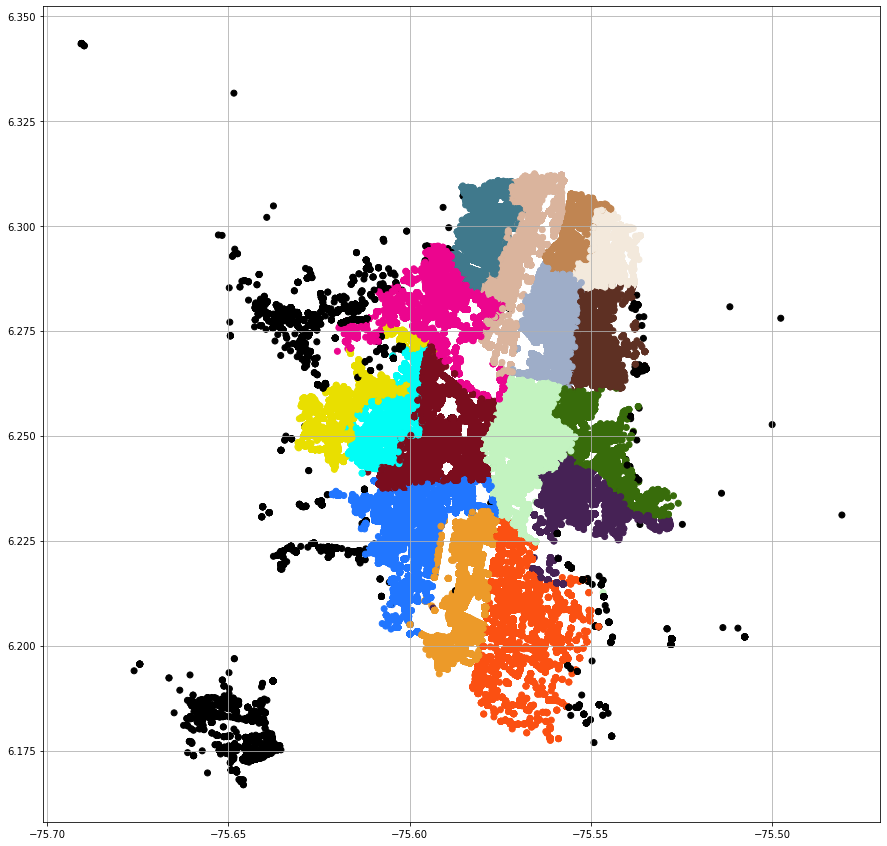

In [25]:
x = list(df['longitud'])
y = list(df['latitud'])
plt.figure(figsize=(15,15))
plt.scatter(x,y,c=asignacion)
plt.grid()

In [26]:
df['colores'] = asignacion 

Como se puede ver los valores negros se hubican su mayoría fuera de Medellín y los que estan dentro son los *nan*, por tanto se decide eliminar estos datos

In [27]:
df = df.set_index('comuna')
df = df.drop(['corregimiento de altavista','corregimiento de san antonio de prado',
                    'corregimiento de san cristóbal','corregimiento de san sebastián de palmitas',
                    'corregimiento de santa elena','corregimiento san antorio de prado'], axis=0)
df = df.reset_index()
df = df.dropna(subset=['comuna'],axis=0)

Tras eliminarlos el nuevo grafico queda de la siguiente forma

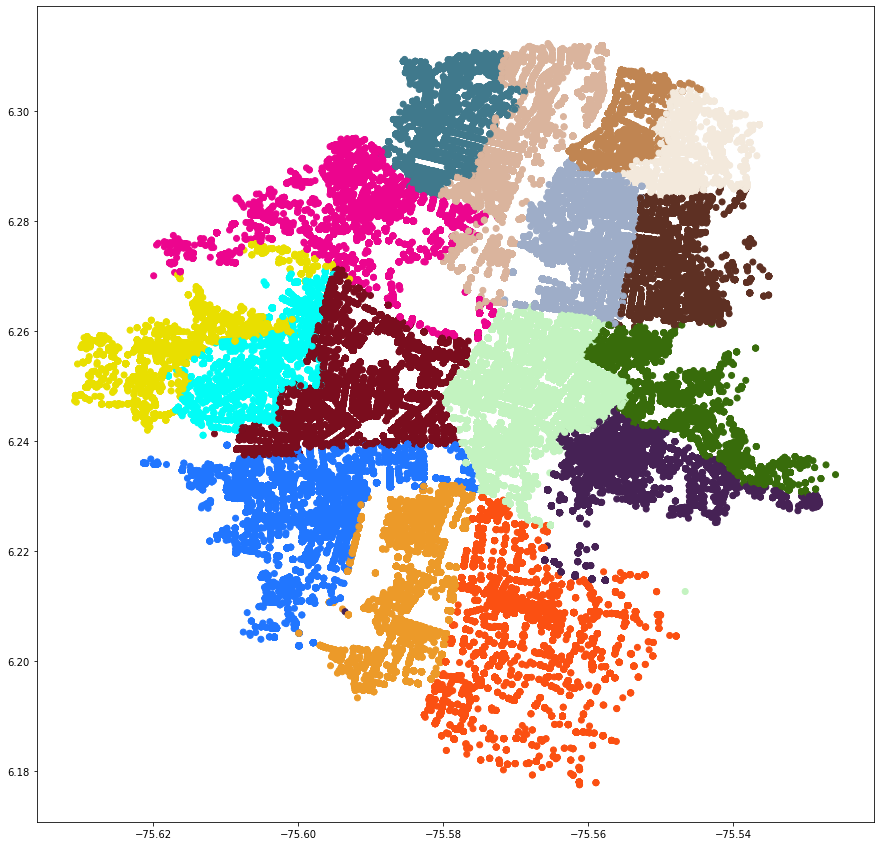

In [28]:
x = list(df['longitud'])
y = list(df['latitud'])
plt.figure(figsize=(15,15))
plt.scatter(x,y,c=list(df['colores']))

In [29]:
#barrios que no existen

# jardín botánico 
# parque norte 
# universidad de antioquia 
# --------
# --------
# barrio caicedo: caicedo
# guayabal -pero tiene comuna buenos aires(debe ser guayabal)
# -------
# cementerio universal 
# oleoducto
# plaza de ferias
# terminal de transporte
# ----
# ----
# el diamante no.2 
# -----
# el rodeo 
# parque juan pablo ii
# ---
# centro administrativo
# corregimiento de santa elena
# hospital san vicente de paúl
# la alpujarra 
# ----
# laureles estadio:laureles
# u.d. atanasio girardot ---talvez es estadio
# u.p.b---probable sea bolivariana
# -----
# manrique---- tiene que ser manrrique central u horiental
# -----
# popular--debe ser 1 o 2
# b. cerro  el volador --- el volador                   
# b. cerro el volador --- el volador
# facultad de minas u. nacional ---- barrio facultada de minas
# facultad veterinaria y zootecnia u.de.a.
# nueva villa de la iguaná --- villa de la iguaná
# universidad nacional .... talvez facultad de minas
# juan xxiii la quiebra -----juan xxiii
# san javier
# sin nombre

In [30]:
d = df.groupby(['comuna','barrio'],dropna=False).count()
d['colores']

comuna            barrio                                  
aranjuez          aranjuez                                     381
                  berlín                                       810
                  bermejal-los alamos                          232
                  brasilia                                     500
                  campo valdés no.1                           1210
                  jardín botánico                              203
                  la piñuela                                   334
                  las esmeraldas                               388
                  manrique central no.1                       1150
                  miranda                                     1049
                  moravia                                     1344
                  palermo                                      358
                  parque norte                                 366
                  san isidro                                  1008
   